# Perform online segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../dev/
from dataset_creation_aprovis3d import aprovis3dDataset

/home/antoine/homhots/aprovhots/dev


In [3]:
import tonic, torch, os, pickle, copy, sys
from tqdm import tqdm
from hots.network import network
from hots.layer import mlrlayer
from hots.timesurface import timesurface
from hots.utils import apply_jitter, get_loader, get_dataset_info, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import imageio.v3 as iio
from IPython.display import Image
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/' #-> default if not mentionned

data_path = '../../Data/RGB_frames2events/'
# gives the data type - here we use experimental data, stored as npy

Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Dataset loading
First we have to create a dataset, it's done with [tonic](https://tonic.readthedocs.io/en/latest/index.html) in order to wrap the data and have a uniform framework. 

In [4]:
data_type = 'synthetic'
# gives a patch_size to divide spatially the event streams
patch_size = (672, 376)
# gives a max duration for the samples of the dataset to divide temporally the event streams
max_duration = 1e3 # (in ms)
# labels given to the different classes of the dataset
labelz = ['sea','gro']
# original sensor_size of the DVS (width,height,polarity)
sensor_size = [672, 376, 2]
# discard samples with less than min_num_events events
min_num_events = 1000
# split the recordings into train and test sets with train_test_ratio ratio
train_test_ratio = .75
# gives the indexing of the event stream
ordering = 'xytp'

trainset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
testset = aprovis3dDataset(save_to=data_path, data_type=data_type, classes=labelz, train=False, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size)
trainloader = get_loader(trainset)
testloader = get_loader(testset)

num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 69
number of samples in the testing set: 24


you should be able to uncomment the following cell in order to build and display a time surface of the recording, can be long to compute for the first time but then it's stored and it allows to have a representation of the signal we gonna use

## Run the core HOTS network

Here you are building the network that will process the event stream and learn in an unsupervised fashion some prototypical and local time surfaces to represent the input data. It captures some regularities and will make 

In [5]:
name = 'homeohots'
homeo = True
timestr = '2023-01-03'
dataset_name = 'aprovis_UCA_no_patch'
ts_batch_size = int(2e4)

tau_0 = 6e3
tau_0 = 2e4

N_neuronz = [64, 16] # number of neurons (kernel) per layer, here you have 2 layers with 64 kernels on L1 and 16 on L2
Rz = [4, 8] # size of the spatial window for local time surfaces
tauz = [tau_0*2, tau_0*16] # time constants for the time surfaces

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))] # filter time surfaces
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
    os.mkdir(record_path+'output/')
    os.mkdir(record_path+'output/train/')
    os.mkdir(record_path+'output/test/')
    os.mkdir(record_path+'LR_results/')
path = record_path+'networks/'+hots.name+'.pkl'
# clustering is the unsupervised learning of prototypical time surfaces
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size)

With the trained network, it's possible to encode the input data into an new event stream, as output of the network (it is stored in record_path, see first cells)

In [6]:
hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=True, ts_batch_size = ts_batch_size, verbose=False)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = None, training=False, ts_batch_size = ts_batch_size, verbose=False)

In [7]:
jitter = (None, None)
type_transform = tonic.transforms.NumpyAsType(int)
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/test/{hots.name}_{num_sample_test}_{jitter}/'

you can uncomment the following cell to make a classification based on the counting of the event: histogram classification (done offline, once all the events are received)

## Divide the event streams into x16 patches
For the patch-based segmentation, you will need to divide the output event stream into local spatial windows of the pixel grid with patch_size. Then you can run the classification layer (MLR) on these events streams defined into local patches. 

In [8]:
patch_size = (16, 16) # size of the patches
max_duration = None # you can set a maximum duration
min_num_events = 10 # minimum number of events per sample
kfold = None # to use only a subset of the dataset

#weird way of splitting dataset between trainsets and testsets but works -> to improve
trainset_output = aprovis3dDataset(save_to=train_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
testset_output = aprovis3dDataset(save_to=test_path, data_type=data_type, classes=labelz, train=True, patch_size=patch_size, max_duration=max_duration, sensor_size=sensor_size, train_test_ratio=1, min_num_events=min_num_events)
trainloader_output = get_loader(trainset_output, kfold = kfold)
testloader_output = get_loader(testset_output)
print(f'number of samples in the training set: {len(trainloader_output)}')
print(f'number of samples in the testing set: {len(testloader_output)}')

number of samples in the training set: 3218
number of samples in the testing set: 1172


## Example with only one layer of Multinomial Logistic Regression (MLR)

In [9]:
ts_batch_size = int(1e3) # to make a batch on the time surfaces and be able to scale to the GPU memory
jitter = (None, None) # if you want to add some jitter
num_workers = 0 # number of active processors in cpu (if I remember correctly)
# training parameters
learning_rate = 0.005
betas = (0.9, 0.999)
num_epochs = 2 ** 5 + 1 # 
N_polarities = N_neuronz[-1] # number of polarities is the number of channels here the output neurons
ts_size = (trainset_output.sensor_size[0],trainset_output.sensor_size[1],N_polarities)
tau_cla = 6e4*32 # time constant of the classification
mlr_layer_name = f'{timestr}_LR_patches_{tau_cla}_{ts_size}_{learning_rate}_{betas}_{num_epochs}_{kfold}_{jitter}.pkl'

model_path = record_path+'networks/' + mlr_layer_name
results_path = record_path+'LR_results/' + mlr_layer_name
train_path = record_path+f'output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = record_path+f'output/train/{hots.name}_{num_sample_test}_{jitter}/'

# runs the learning of the classification layer
classif_layer, losses = fit_mlr(trainloader_output, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size,)

Testing the classification layer

Number of chance decisions: 0
90th quantile for number of events: 11507.200000000008
Mean accuracy: 68.10000000000001%
Last accuracy: 61.3%
Highest probability accuracy: 56.10000000000001%


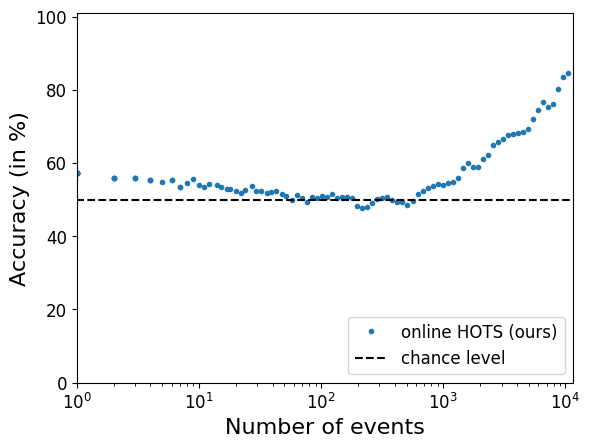

In [10]:
mlr_threshold = None

onlinac, best_probability, meanac, lastac  = online_accuracy(classif_layer, tau_cla, testloader_output, results_path, ts_size, trainset.ordering, len(labelz), mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, original_accuracy = None, original_accuracy_nohomeo = None, online_plot=True)

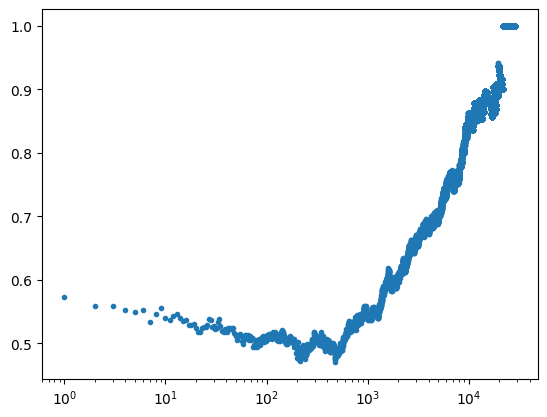

In [11]:
plt.semilogx(onlinac, '.')